In [6]:
import os
import sys
from PIL import Image
from osgeo import gdal
import numpy as np
import rasterio
from osgeo import osr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

import glob
import os

import re
import datetime

from PIL import Image


import numpy as np
import pandas as pd

from sklearn.metrics import multilabel_confusion_matrix


from hyperopt import hp
from hyperopt import fmin, pyll, tpe, hp, STATUS_OK, Trials

import pickle
import time

import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D

In [7]:
#Load the model
model_improved = keras.models.load_model("17_model_improved")

In [8]:
# add here the folder path, where your  data is stored
directory = "E:/W_Katrin/Kigali/Raster/tiles"
files = glob.glob(os.path.join(directory,'*'))

pattern_img = '.*\.jpg'
# create a list of all images in that directory [after converting them to jpg with the code in Github README]
files_img = list(filter(re.compile(pattern_img).match,files))

files_img = sorted(files_img)

print('Image files: {}\n'.format(len(files_img)))

Image files: 1717



In [9]:
# create a dataframe of the satellite images and their respective mask 
df_files = pd.DataFrame(columns=['img'])
df_files['img'] = files_img

# return a random sample [frac defines how big of a fraction of the original data the sampled data should be; 1 means equal]
df_files = df_files.sample(frac=1,random_state=10)

In [10]:
def make_test_gen(df_test,target_size,batch_size,seed):# this function generates augmented data[!not only training data!]
    # or better said: it generates a function which generates augmented data[generator function]
    
    # https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
    # generate batches of tensor image data with real-time data augmentation 
    # batches of original training data are randomly transformed and then used for training (not the original data!)
  test_gen = keras.preprocessing.image.ImageDataGenerator()
    
    # read data from dataframe and perform powerful on-the-fly image augmentation with ImageDataGenerator
  test_generator = test_gen.flow_from_dataframe(
          dataframe=df_test,        
          x_col='img',
          target_size=target_size,
          batch_size=batch_size,
          seed = seed,
          class_mode=None,
          color_mode='rgb',
          shuffle=False)
  return test_generator


In [11]:
test_image_gen = make_test_gen(df_files, batch_size = 1,target_size = (256, 256), seed = 0) #seed 0 to keep the Reihenfolge
img_test = next(test_image_gen)
print(img_test.shape)

Found 1716 validated image filenames.
(1, 256, 256, 3)


E:\W_Katrin\miniconda3\envs\tue_dl2\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  warnings.warn(


In [12]:
# Generate output predictions for the input samples
mask_predicted = model_improved.predict(test_image_gen, verbose = 1)

1716/1716 [==============================] - 204s 119ms/step


In [13]:
# analyse mask predicted
print(mask_predicted.shape)
print(type(mask_predicted))


(1716, 256, 256, 3)
<class 'numpy.ndarray'>


In [20]:
from osgeo import gdal
file = "E:/W_Katrin/Kigali/Raster/tiles/testing_0_0.jpg"
img = gdal.Open(file)
img = img.ReadAsArray()
img.shape

(3, 256, 256)

In [49]:
#save predicted maps

savedir = "E:/W_Katrin/Kigali/Raster/tiles/predicted_m17"
for i in range(len(mask_predicted)): 
    mask_pred = np.squeeze(mask_predicted[i])
    #print(mask_pred)
    #print(mask_pred.dtype)
    mask_pred = (255*(mask_pred - np.min(mask_pred))/np.ptp(mask_pred)).astype("uint8")  
    #break
    save_to = os.path.join(savedir, "testing_{x}.jpg".format(x = i))
    imageio.imwrite(save_to, mask_pred)

In [50]:
# define function to display the results
def predict_buildings(img, mask_pred):
    i=0
    img=img[i].astype(int)
    mask_pred=np.squeeze(mask_pred[i])
    mask_pred_rend=np.argmax(mask_pred, axis=-1)
    plt.figure(figsize=0.8*np.array([3*6.4, 4.8]))
    plt.subplot(131) # = plt.subplot(1,3,1), 1 row, 4 columns,  first subplot (from right to left, first top row)
    plt.imshow(img)
    plt.subplot(132)
    plt.imshow(mask_pred)
    plt.subplot(133)
    plt.imshow(mask_pred_rend)
    plt.show()
    
    return mask_pred, mask_pred_rend

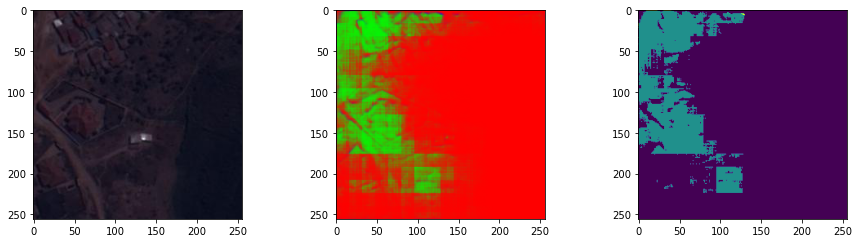

In [51]:
mask_predicted_, mask_predicted_rend_= predict_buildings(img_test, mask_predicted)

In [52]:
mask_predicted_rend_

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Put Images back together
### 1) zip testing and mask and put them together in a dataframe 
### 2) extract position from testing name 
### 3) somehow generate a mosaic

In [65]:
# add here the folder path, where your SpaceNet data is stored
directory_img = 'E:/W_Katrin/Kigali/Raster/tiles'


files = glob.glob(os.path.join(directory_img,'*'))
pattern_img = '.*\.jpg$'
files_img = list(filter(re.compile(pattern_img).match,files))
files_img = sorted(files_img)

directory_mask = "E:/W_Katrin/Kigali/Raster/tiles/predicted_m17"
files = glob.glob(os.path.join(directory_mask,'*'))
pattern_mask = '.*\.jpg$'
files_mask = list(filter(re.compile(pattern_mask).match,files))
files_mask = sorted(files_mask)


print(' All files: {}\n'.format(len(files)),
      'Image files: {}\n'.format(len(files_img)), 
      'Mask files: {}'.format(len(files_mask)))

 All files: 1716
 Image files: 1716
 Mask files: 1716


In [66]:
# create a dataframe of the satellite images and their respective mask 
df_files = pd.DataFrame(columns=['img','mask'])
df_files['img'] = files_img
df_files['mask'] = files_mask

In [73]:
df_files

img     E:/W_Katrin/Kigali/Raster/tiles\testing_0_1024...
mask    E:/W_Katrin/Kigali/Raster/tiles/predicted_m17\...
Name: 1, dtype: object

In [74]:
df_files.iloc[1]

img     E:/W_Katrin/Kigali/Raster/tiles\testing_0_1024...
mask    E:/W_Katrin/Kigali/Raster/tiles/predicted_m17\...
Name: 1, dtype: object